In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpes import fprocessing as fp, analysis as aly
from mpes import visualization as vis
#from itkwidgets import view
from lmfit import Model, CompositeModel
import lmfit.models as lmm
from h5py import File
import scipy.io as sio

In [4]:
from imp import reload
reload(fp)

<module 'mpes.fprocessing' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\mpes\\fprocessing.py'>

In [5]:
fdir = r'E:\FLASH_Beamtime\Results'

In [6]:
bd125 = fp.readBinnedhdf5(fdir + r'\Run=22125_4axis_80x80x146x230.h5')
bd127 = fp.readBinnedhdf5(fdir + r'\Run=22127_4axis_80x80x146x230.h5')
bd130 = fp.readBinnedhdf5(fdir + r'\Run=22130_4axis_80x80x146x230.h5')

In [8]:
bd125['V'].shape

(80, 80, 146, 231)

In [10]:
bvol = (bd125['V'][...,25:220] + bd127['V'][...,18:213] + bd130['V'][...,6:201])/3

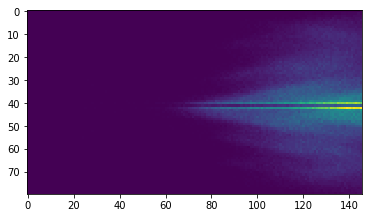

In [20]:
plt.imshow(bvol[:,:,:,100:150].sum(axis=(0,3)))

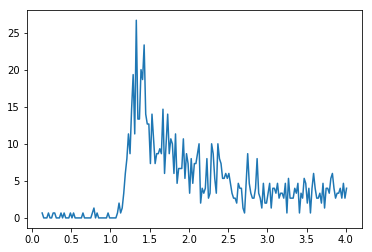

In [23]:
tsig = bvol[:,:,:36,:].sum(axis=(0,1,2))[::-1]
tdelay = bd125['tPP'][36:] + 513.5
plt.plot(tdelay, tsig)

In [24]:
bvol.shape

(80, 80, 146, 195)

In [19]:
bd125.keys()

dict_keys(['ToF', 'pX', 'pY', 'tPP', 'V'])

In [21]:
mc = aly.MomentumCorrector(bvol.sum(axis=3))

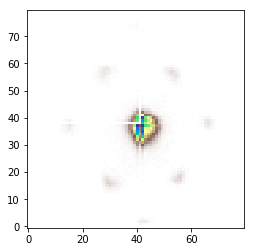

In [28]:
mc.selectSlice2D(slice(70, 90), axis=2)
mc.view(mc.slice)

In [49]:
mc.featureExtract(image=mc.slice, method='daofind', sigma=5, fwhm=6)

In [56]:
mc.pouter_ord[5,:] = np.array([37, 15])

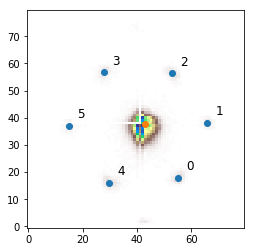

In [57]:
mc.view(mc.slice, annotated=True, points=mc.features)

In [72]:
kcalib = mc.calibrate(mc.slice, mc.pouter_ord[3,:], mc.pcent, 1.27, ret=['coeffs', 'axes'], equiscale=True)

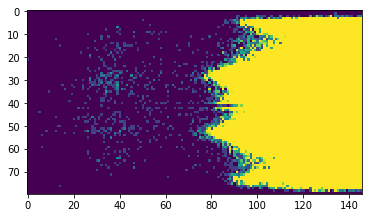

In [88]:
plt.imshow(mc.image[50:80, ...].sum(axis=0), vmin=0, vmax=0.0005)

In [93]:
# eax = -(4.5/146)*np.arange(0, 146)+2.5

In [81]:
mc.image[50, ...].max()

0.007762531

In [108]:
# Time axis (fitting the end of notebook)
tax = np.linspace(-1.1, 2.7, 195)

In [109]:
tax.shape

(195,)

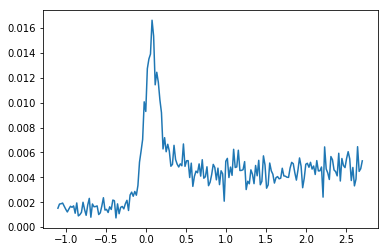

In [111]:
plt.plot(tax, bvol[:,:,:70,:].sum(axis=(0,1,2))[::-1])

In [ ]:
def saveHDF(*groups, save_addr='./file.h5', track_order=True, **kwds):
    """ Combine dictionaries and save into a hierarchical structure.
    :Parameters:
        groups : list/tuple
            Group specified in the following manner that incorporates the name as a string
            and the content and or substructure as a dictionary, ['folder_name', folder_dict].
        save_addr : str | './file.h5'
            File directory for saving the HDF.
    """

    try:
        hdf = File(save_addr, 'w')

        for g in groups:
            grp = hdf.create_group(g[0], track_order=track_order)

            for gk, gv in g[1].items():
                grp.create_dataset(gk, data=gv, **kwds)

    finally:
        hdf.close()

In [115]:
dicta = [['axes', {'kx':kcalib['axes'][0], 'ky':kcalib['axes'][1], 'E':erange, 'tpp':tax}],
         ['binned', {'V':bvol[...,::-1]}]]

In [116]:
saveHDF(*dicta, save_addr=r'.\2018_WSe2_LCPpump_LPprobe.h5')

### Normalization

In [6]:
bd125['V'] = bd125['V']/np.sum(bd125['V'], axis=(0,1,2), keepdims=True)
bd127['V'] = bd127['V']/np.sum(bd127['V'], axis=(0,1,2), keepdims=True)
bd130['V'] = bd130['V']/np.sum(bd130['V'], axis=(0,1,2), keepdims=True)

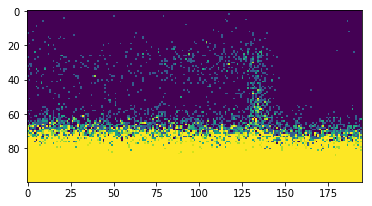

In [7]:
plt.imshow(bd125['V'][:,:,:100,25:220].sum(axis=(0,1)), vmax=1e-3)

Text(0,0.5,'Energy (a.u.)')

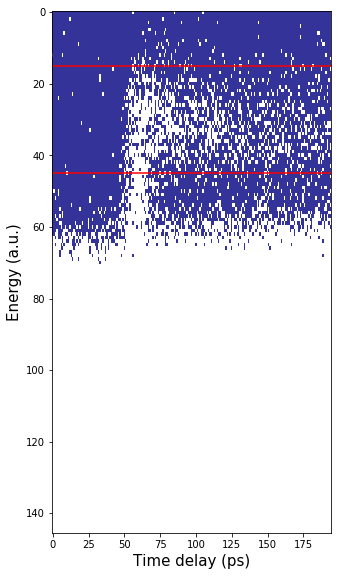

In [153]:
tshift = 0
E = bd125['ToF'][5:75]
Eseq = range(len(E))
plt.figure(figsize=(5, 10))
imvol = bvol[:,:,:,:].sum(axis=(0,1))[:,::-1]
plt.imshow(imvol, aspect=2.5, vmax=7e-4, cmap='terrain')
plt.axhline(y=Eseq[15], color='r')
plt.axhline(y=Eseq[45], color='r')
# plt.yticks([])
plt.xlabel('Time delay (ps)', fontsize=15)
plt.ylabel('Energy (a.u.)', fontsize=15)
#plt.title('Circularly polarized excitation (QWP=183$^{\circ}$)')

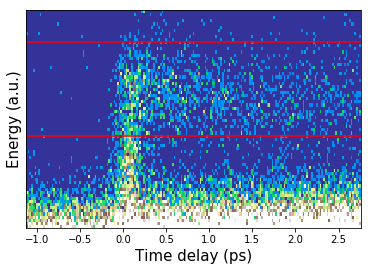

In [100]:
E = bd125['ToF'][5:75]
Eseq = range(len(E))
plt.imshow(bvol[:,:,5:75,:].sum(axis=(0,1))[:,::-1], aspect='auto', vmax=7e-4, cmap='terrain',\
          extent=[tdelay[0]-tshift, tdelay[-1]-tshift, Eseq[-1], Eseq[0]])
plt.axhline(y=Eseq[10], color='r')
plt.axhline(y=Eseq[40], color='r')
plt.yticks([])
plt.xlabel('Time delay (ps)', fontsize=15)
plt.ylabel('Energy (a.u.)', fontsize=15)
#plt.title('Circularly polarized excitation (QWP=183$^{\circ}$)')
plt.savefig('Combined_Etmap_norm_QWP=183.png', bbox_inches='tight', dpi=300)

In [ ]:
tvolE = tvol[...,:].sum(axis=2)
plt.imshow(tvolE, vmax=5)

### Correction for t$_0$ drift

Text(0.5,1,'Conduction band signal (no adjustment)')

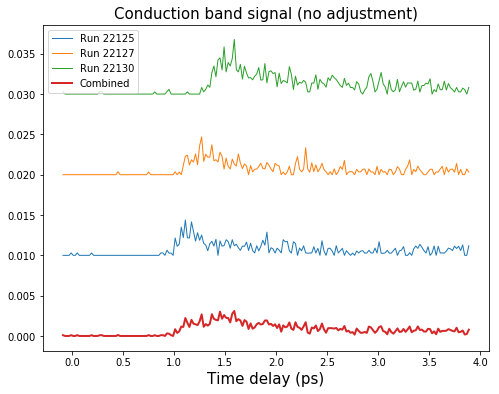

In [9]:
pxls = [10, 40]

Ecuts = slice(pxls[0], pxls[1])
cuts = slice(20, 220)

sc125 = bd125['V'][:,:,Ecuts,:].sum(axis=(0,1,2))
sc127 = bd127['V'][:,:,Ecuts,:].sum(axis=(0,1,2))
sc130 = bd130['V'][:,:,Ecuts,:].sum(axis=(0,1,2))

sc125_tr_noadj = sc125[cuts][::-1]
sc127_tr_noadj = sc127[cuts][::-1]
sc130_tr_noadj = sc130[cuts][::-1]

#tsig = bvol[:,:,:14,40:240].sum(axis=(0,1,2))[::-1]
tsig_noadj = (sc125_tr_noadj + sc127_tr_noadj + sc130_tr_noadj) / 3
tdelay = bd125['tPP'][cuts] + 513.6

plt.figure(figsize=(8, 6))
plt.plot(tdelay, sc125_tr_noadj + 0.01, lw=1, label='Run 22125')
plt.plot(tdelay, sc127_tr_noadj + 0.02, lw=1, label='Run 22127')
plt.plot(tdelay, sc130_tr_noadj + 0.03, lw=1, label='Run 22130')
plt.plot(tdelay, tsig_noadj, lw=2, label='Combined')
plt.legend()
plt.xlabel('Time delay (ps)', fontsize=15)
plt.title('Conduction band signal (no adjustment)', fontsize=15)
# plt.savefig('Tshift_noadjust_22125-22130_upper.png', bbox_inches='tight', dpi=300)

Text(0.5,1,'Conduction band signal (t$_0$ shift adjusted)')

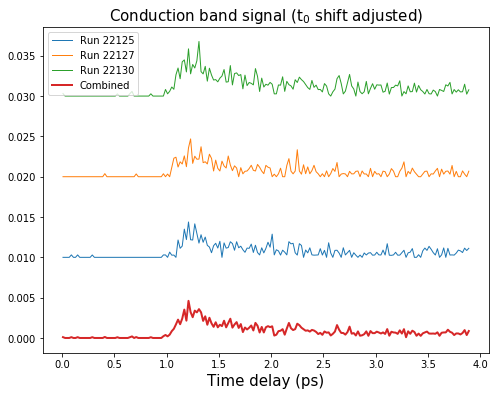

In [10]:
sc125 = bd125['V'][:,:,Ecuts,:].sum(axis=(0,1,2))
sc127 = bd127['V'][:,:,Ecuts,:].sum(axis=(0,1,2))
sc130 = bd130['V'][:,:,Ecuts,:].sum(axis=(0,1,2))

sc125_tr_adj = sc125[25:220][::-1]
sc127_tr_adj = sc127[18:213][::-1]
sc130_tr_adj = sc130[6:201][::-1]

#tsig = bvol[:,:,:14,40:240].sum(axis=(0,1,2))[::-1]
tsig_adj = (sc125_tr_adj + sc127_tr_adj + sc130_tr_adj) / 3
tdelay = bd125['tPP'][25:220] + 513.6

plt.figure(figsize=(8, 6))
plt.plot(tdelay, sc125_tr_adj + 0.01, lw=1, label='Run 22125')
plt.plot(tdelay, sc127_tr_adj + 0.02, lw=1, label='Run 22127')
plt.plot(tdelay, sc130_tr_adj + 0.03, lw=1, label='Run 22130')
plt.plot(tdelay, tsig_adj, lw=2, label='Combined')
plt.legend()
plt.xlabel('Time delay (ps)', fontsize=15)
plt.title('Conduction band signal (t$_0$ shift adjusted)', fontsize=15)
# plt.savefig('Tshift_adjusted_22125-22130_upper.png', bbox_inches='tight', dpi=300)

In [11]:
sc125.shape

(231,)

### Linear detrending

In [40]:
import scipy.signal as ss

[[Model]]
    Model(linear)
[[Variables]]
    intercept:   91.1265816 +/- 2.793874 (3.07%) (init= 0)
    slope:       18.9010322 +/- 1.359590 (7.19%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(intercept, slope)          = -0.827 



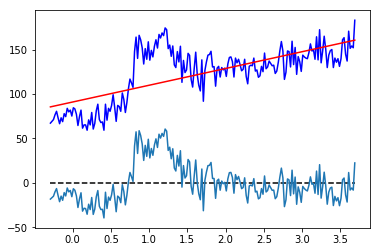

In [11]:
mod = lmm.LinearModel(nan_policy='propagate')
pars = mod.make_params()
pars = mod.guess(data=tdelay, y=tsig)
out = mod.fit(tsig, pars, x=tdelay)
print(out.fit_report())

plt.plot(tdelay, tsig, 'b')
plt.plot(tdelay, out.init_fit, 'k--')
plt.plot(tdelay, out.best_fit, 'r-')
plt.plot(tdelay, tsig - out.best_fit)
plt.show()

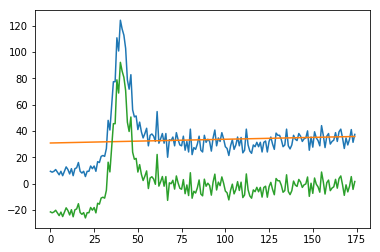

In [37]:
tsig_dtrnd = ss.detrend(tsig_adj)
plt.plot(tsig_adj)
plt.plot(tsig_adj - tsig_dtrnd)
plt.plot(tsig_dtrnd)

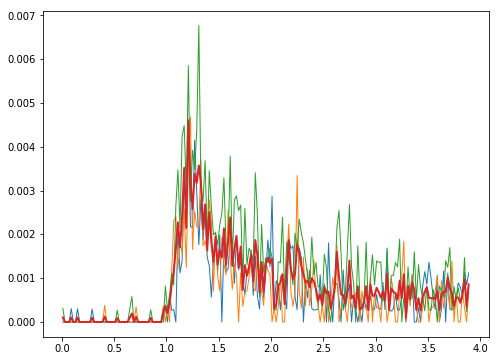

In [104]:
bkrm = False
if bkrm:
    sc125_dtrnd = ss.detrend(sc125_tr_adj)
    sc127_dtrnd = ss.detrend(sc127_tr_adj)
    sc130_dtrnd = ss.detrend(sc130_tr_adj)
    sigs = [sc125_dtrnd/1, sc127_dtrnd, sc130_dtrnd/1]
else:
    sigs = [sc125_tr_adj/1, sc127_tr_adj, sc130_tr_adj/1]
#sigs = [sc125_tr_adj/1.5, sc127_tr_adj, sc130_tr_adj/1.5]
sigs = np.asarray(sigs)
sig_avg = sigs.mean(axis=0)

plt.figure(figsize=(8, 6))
for sig in sigs:
    plt.plot(tdelay, sig, lw=1)
plt.plot(tdelay, sig_avg, lw=2)

In [24]:
defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

tdelay -= tshift
plt.figure(figsize=(8, 6))
plt.plot(tdelay, sc125_tr_adj + 100, color=defcolors[0], lw=1, label='Run 22124')
plt.plot(tdelay, sc125_tr_adj - sc125_dtrnd + 100, 'k', lw=1)
plt.plot(tdelay, sc125_dtrnd, color=defcolors[0])
plt.plot(tdelay, sc127_tr_adj + 200, color=defcolors[1], lw=1, label='Run 22126')
plt.plot(tdelay, sc127_tr_adj - sc127_dtrnd + 200, 'k', lw=1)
plt.plot(tdelay, sc127_dtrnd, color=defcolors[1])
plt.plot(tdelay, sc130_tr_adj + 300, color=defcolors[2], lw=1, label='Run 22128')
plt.plot(tdelay, sc130_tr_adj - sc130_dtrnd + 300, 'k', lw=1)
plt.plot(tdelay, sc130_dtrnd, color=defcolors[2])

plt.legend()
plt.xlabel('Time delay (ps)', fontsize=15)
plt.title('Signal detrending', fontsize=15)
#plt.savefig('Detrending_adjusted_22125-22130.png', bbox_inches='tight', dpi=300)

NameError: name 'tshift' is not defined

### Complex model construction and fitting

In [22]:
from scipy.special import erf
from math import sqrt

def impulse_response(t, A, tau, Del, mu, c):
    
    k = 1/tau
    z = (t - mu - k*Del**2) / (sqrt(2)*Del)
    curve = A*np.exp(-k*t)*np.exp(k*(mu + 0.5*k*Del**2))*(1 + erf(z)) + c
    
    return curve

def impulse_responses(t, A, tau1, tau2, Del, mu, c):
    """ Includes multiple tau values
    """
    
    ks = np.array([1/tau1, 1/tau2])
    curve = 0
    for k in ks:
        z = (t - mu - k*Del**2) / (sqrt(2)*Del)
        curve += A*np.exp(-k*t)*np.exp(k*(mu + 0.5*k*Del**2))*(1 + erf(z))
    curve += c
    
    return curve

def impulse_responses(t, A1, A2, tau1, tau2, Del, mu, c):
    """ Includes multiple tau values
    """
    
    ks = np.array([1/tau1, 1/tau2])
    As = np.array([A1, A2])
    curve = 0
    for k, A in zip(ks, As):
        z = (t - mu - k*Del**2) / (sqrt(2)*Del)
        curve += A*np.exp(-k*t)*np.exp(k*(mu + 0.5*k*Del**2))*(1 + erf(z))
    curve += c
    
    return curve

def impulse_responses(t, A1, A2, tau, Del, mu, c):
    """ Includes multiple tau values
    """

    k1 = 1/tau
    k2 = 0.
    z = (t - mu - k1*Del**2) / (sqrt(2)*Del)
    curve = A1*np.exp(-k1*t)*np.exp(k1*(mu + 0.5*k1*Del**2))*(1 + erf(z)) + \
    A2*np.exp(-k2*t)*np.exp(k2*(mu + 0.5*k2*Del**2))*(1 + erf(z)) + c

    return curve

def impulse_responses2(t, A1, A2, tau1, tau2, Del, mu):
    """ Includes multiple tau values
    """

    k1 = 1/tau1
    k2 = 1/tau2
    z = (t - mu - k1*Del**2) / (sqrt(2)*Del)
    curve = A1*np.exp(-k1*t)*np.exp(k1*(mu + 0.5*k1*Del**2))*(1 + erf(z)) + \
    A2*np.exp(-k2*t)*np.exp(k2*(mu + 0.5*k2*Del**2))*(1 + erf(z))

    return curve

def impulse_responses3(t, A1, A2, A3, tau1, tau2, Del, mu):
    """ Includes multiple tau values
    """

    k1 = 1/tau1
    k2 = 1/tau2
    k3 = 0.
    z = (t - mu - k1*Del**2) / (sqrt(2)*Del)
    curve = A1*np.exp(-k1*t)*np.exp(k1*(mu + 0.5*k1*Del**2))*(1 + erf(z)) + \
    A2*np.exp(-k2*t)*np.exp(k2*(mu + 0.5*k2*Del**2))*(1 + erf(z)) + \
    A3*np.exp(-k3*t)*np.exp(k3*(mu + 0.5*k3*Del**2))*(1 + erf(z))

    return curve

In [109]:
sig_avg = bvol[:,:,18:43,:].sum(axis=(0,1,2))[::-1]

In [110]:
tdelay.shape

(195,)

In [111]:
sig_avg.shape

(195,)

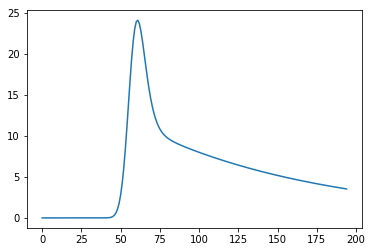

In [145]:
mod = Model(impulse_responses2)
#pars = mod.make_params(A1=20, A2=5, tau=0.1, Del=0.1, mu=1, c=-10)
pars = mod.make_params(A1=10, A2=2, tau1=0.08, tau2=3, Del=0.1, mu=1, c=-0.001)
# pars = mod.make_params(A1=10, A2=2, A3=1, tau1=0.08, tau2=1, tau3=15, Del=0.1, mu=1, c=-0.001)
#pars['tau1'].set(min=0.1)
#pars = mod.make_params(A1=0.004, A2=0.001, A3=0.0005, tau1=0.2, tau2=1., Del=0.1, mu=1)
#pars = mod.guess(data=tdelay, y=sig_avg)
out = mod.fit(sig_avg, pars, t=tdelay)
plt.plot(out.best_fit)

In [146]:
2*np.sqrt(np.log(2))

1.6651092223153954

In [147]:
print(out.fit_report())

[[Model]]
    Model(impulse_responses2)
[[Variables]]
    A1:     39.2043860 +/- 46.44084 (118.46%) (init= 10)
    A2:     5.80270277 +/- 0.386097 (6.65%) (init= 2)
    tau1:   0.06905360 +/- 0.054773 (79.32%) (init= 0.08)
    tau2:   2.30179782 +/- 0.284038 (12.34%) (init= 3)
    Del:    0.08698362 +/- 0.023736 (27.29%) (init= 0.1)
    mu:     1.26926456 +/- 0.062351 (4.91%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(A1, tau1)                  = -0.997 
    C(A1, mu)                    =  0.996 
    C(tau1, mu)                  = -0.992 
    C(A1, Del)                   =  0.969 
    C(Del, mu)                   =  0.967 
    C(tau1, Del)                 = -0.950 
    C(A2, tau2)                  = -0.854 
    C(tau1, tau2)                =  0.429 
    C(A1, tau2)                  = -0.395 
    C(tau2, mu)                  = -0.374 
    C(tau2, Del)                 = -0.313 
    C(A2, tau1)                  = -0.173 
    C(A1, A2)                    =  0.1

In [148]:
tshift = out.best_values['mu']

Text(0.5,0,'Time delay (ps)')

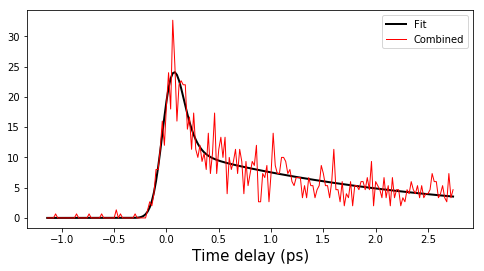

In [149]:
plt.figure(figsize=(8, 4))
plt.plot(tdelay - tshift, out.best_fit, 'k', lw=2, label='Fit')
plt.plot(tdelay - tshift, sig_avg, 'r', lw=1, label='Combined')

plt.legend()
plt.xlabel('Time delay (ps)', fontsize=15)

In [150]:
import scipy.io as sio

In [152]:
sio.savemat('WSe2_ES_trace_183.mat', {'sig':sig_avg, 'fit':out.best_fit, 'ts':tdelay - tshift, 'polar':183})

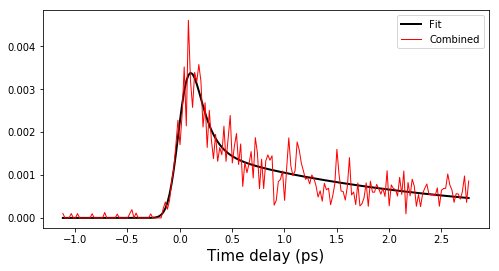

In [110]:
plt.figure(figsize=(8, 4))
plt.plot(tdelay - tshift, out.best_fit, 'k', lw=2, label='Fit')
plt.plot(tdelay - tshift, sig_avg, 'r', lw=1, label='Combined')

plt.legend()
plt.xlabel('Time delay (ps)', fontsize=15)
plt.savefig('Fit_combined_norm_CB_QWP=183_2exp.png', bbox_inches='tight', dpi=300)

In [111]:
import scipy.io as sio

In [112]:
sio.savemat('FLASH_QWP=183.mat', {'sig_183':sig_avg, 't_183':tdelay - tshift})

In [ ]:
mod = lmm.LinearModel(nan_policy='propagate')
pars = mod.make_params()
pars = mod.guess(data=tdelay, y=tsig)
out = mod.fit(tsig, pars, x=tdelay)
print(out.fit_report())

plt.plot(tdelay, tsig, 'b')
plt.plot(tdelay, out.init_fit, 'k--')
plt.plot(tdelay, out.best_fit, 'r-')
plt.plot(tdelay, tsig - out.best_fit)
plt.show()

### Energy calibration

In [133]:
cad = sio.loadmat('E:\FLASH_Beamtime\Results\calib.mat')

In [134]:
cad.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ToF', 'pX', 'pY', 'curves'])

In [135]:
cad['curves'].shape

(4, 80, 80, 1458)

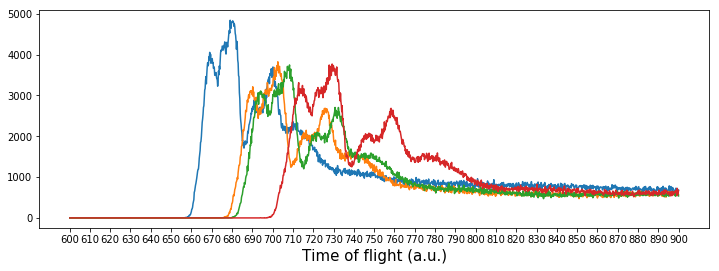

In [136]:
biases = [26.5, 29.0, 29.5, 31.5]
traces = cad['curves'].sum(axis=(1,2))
plt.figure(figsize=(12, 4))
plt.plot(cad['ToF'].T, traces.T)
# plt.plot(traces.T)
plt.xlabel('Time of flight (a.u.)', fontsize=15)
plt.xticks(np.arange(600, 901, 10));

In [121]:
ec = aly.EnergyCalibrator(biases=biases, traces=traces, tof=cad['ToF'].ravel())
ec.normalize(smooth=True, span=11, order=1)

In [145]:
ec.addFeatures(ranges=[[666, 673],[685, 693],[690, 698],[710, 718]], infer_others=False, mode='replace')
ec.featureExtract()

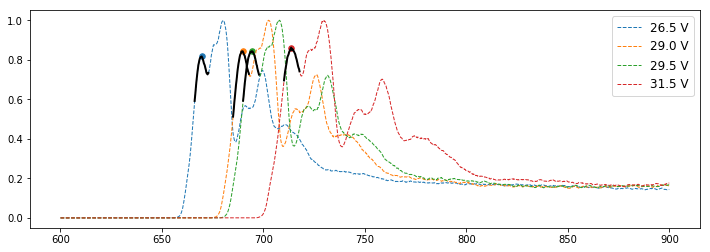

In [149]:
ec.view(ec.traces_normed, segs=ec.featranges, peaks=ec.peaks, backend='matplotlib')

In [157]:
tof2e = ec.calibrate(ret='func', calib_ret=True)
ec.calibration

functools.partial(<function tof2evpoly at 0x0000026BAA2D8C80>, array([ 5.73165512e-06, -1.23194754e-02,  8.92659492e+00]))

In [158]:
ec.view??

In [201]:
erange = -tof2e(t=bd125['ToF'], E0=-2175)

In [169]:
erange[-1] - erange[0]

3.9084473

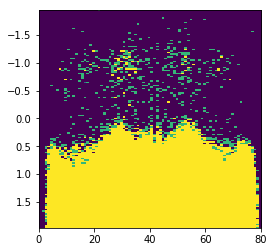

In [202]:
plt.imshow(bvol[50:, ...].sum(axis=(0,3)).T, vmin=0, vmax=1, extent=[0, 80, erange[0], erange[-1]], aspect=20)